In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import ParserError
import cycler
import matplotlib.ticker as ticker
import numpy as np

### Inputs

In [2]:
# Results directory
results_directory = './easymore_results/full_results/'

subbasin_id= '58408'

# start and end dates for the calculation of average annual flow
start_date= '2060-01-01'

end_date= '2090-12-31'

# variable
variable= 'cout' 

historical_path= './0058408.txt'


### Analysis

Future Climate

In [3]:
# Get a list of all text files containing '58208' in the directory
file_list = [os.path.join(results_directory, filename) for filename in os.listdir(results_directory) if subbasin_id in filename]

In [4]:
# Create an empty list to store xarray DataArrays
data_arrays = []

# Loop through each file
for file_path in file_list:
    # Read the file into a pandas DataFrame
    df = pd.read_csv(file_path, sep='\t', index_col=0)

    # Drop the first row
    df = df.iloc[1:]
    
    # Convert the DataFrame to an xarray DataArray
    data_array = xr.DataArray(df.values, dims=('DATE', 'variable'), coords={'DATE': df.index, 'variable': df.columns})
    
    # Append the Data|Array to the list
    data_arrays.append(data_array)

# Concatenate the list of DataArrays along a new dimension 'variable'
ds = xr.concat(data_arrays, dim='member')

In [5]:
# Convert 'DATE' coordinate to datetime, specifying the format and handling errors
ds['DATE'] = pd.to_datetime(ds['DATE'])

# Convert 'member' coordinate to float
ds = ds.astype(float)

In [6]:
# Select the 'cout' variable from the dataset
var_data = ds.sel(variable=variable)

In [7]:
# Sort the dataset along the 'DATE' coordinate
var_data = var_data.sortby('DATE')

# Filter the sorted dataset to include only data between the specified dates
var_data = var_data.sel(DATE=slice(start_date, end_date))

In [8]:
# Calculate the mean of these daily means for each member to get the average annual runoff
average_annual_runoff = var_data.groupby('DATE.dayofyear').mean(dim='DATE')

In [9]:
# Drop the 60th value for each member
# average_annual_runoff = average_annual_runoff.sel(dayofyear=~(average_annual_runoff['dayofyear'] == 60))

Historical Simulation

In [10]:
# Read the tab-separated text file into a DataFrame
sim = pd.read_csv(historical_path, delimiter='\t', index_col=0)

In [11]:
# Drop the first row
sim = sim.iloc[1:]

In [12]:
# Drop all columns except for 'variable'
sim = sim[[variable]]

In [13]:
# Convert index to datetime
sim.index = pd.to_datetime(sim.index)

In [14]:
# Trim the DataFrame between dates
sim = sim.loc['1981-01-01':'2015-12-31']

In [15]:
# Get the length of the DataFrame before dropping NaN values
original_length = len(sim)

In [16]:
# Convert the 'cout' column to numeric
sim[variable] = pd.to_numeric(sim[variable], errors='coerce')

In [17]:
# Drop NaN values if any
sim = sim.dropna()

In [18]:
# Get the length of the DataFrame after dropping NaN values
new_length = len(sim)

In [19]:
# Check if any NaN values were replaced
if new_length < original_length:
    print("NaN values were replaced during conversion.")
else:
    print("No NaN values were replaced during conversion.")

No NaN values were replaced during conversion.


In [20]:
# Resample the data to calculate the mean for each day of the year across all years
sim_resampled = sim.groupby(sim.index.dayofyear)[variable].mean()

In [21]:
# Drop the 60th date in sim_resampled to drop leap day
# sim_resampled = sim_resampled.drop(60)

In [22]:
# Calculate the percentiles, adjust as required
low_percentile = average_annual_runoff.quantile(0, dim='member')
high_percentile = average_annual_runoff.quantile(1, dim='member')

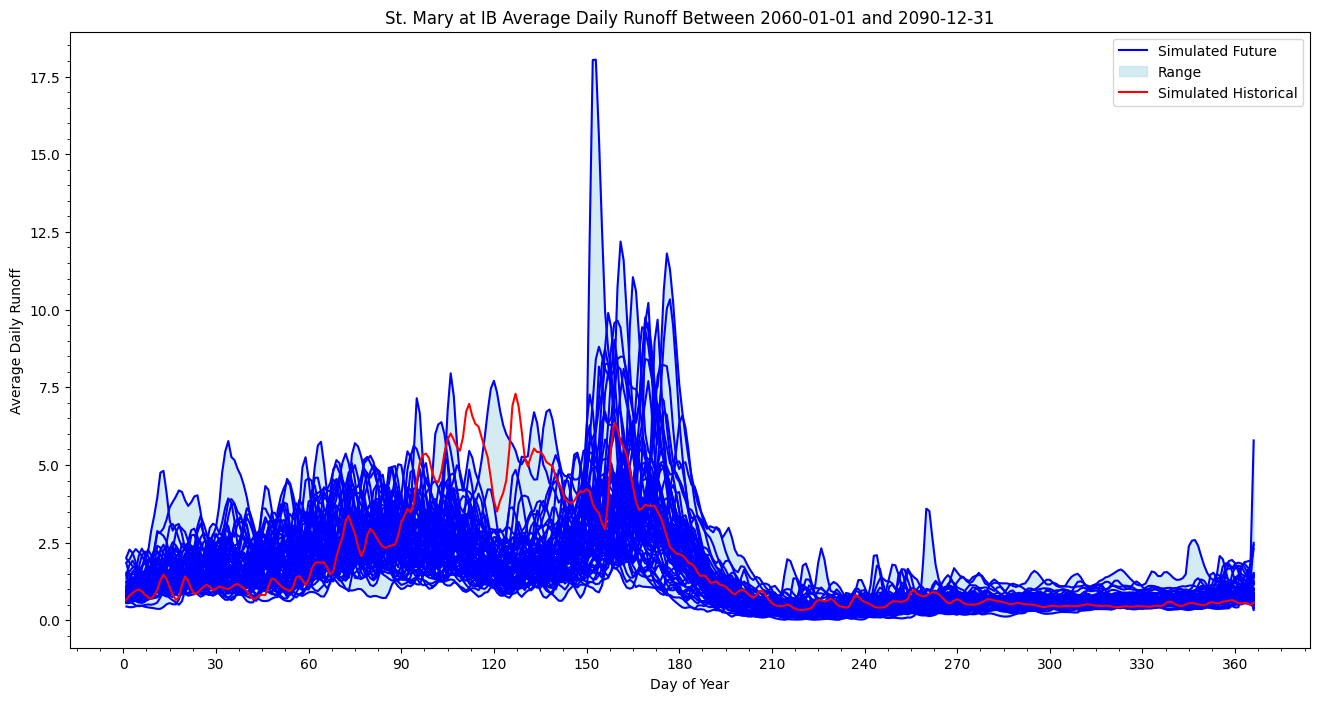

In [23]:
# Plot the average annual runoff for all members with a single label and color
average_annual_runoff.plot.line(x='dayofyear', color='blue', aspect=2, size=4, label='Simulated Future')

# Plot sim_resampled
sim_resampled.plot(label='Simulated Historical', color='red')

# Get the handles and labels for the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Remove duplicate legend entries
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

        # Add shaded area to the legend for the first appearance of 'Average Annual Runoff'
        if label == 'Simulated Future':
            shade_legend = plt.fill_between(average_annual_runoff['dayofyear'], low_percentile, high_percentile, color='lightblue', alpha=0.5)
            unique_handles.append(shade_legend)
            unique_labels.append('Range')

plt.xlabel('Day of Year')
plt.ylabel('Average Daily Runoff')
plt.title(f'St. Mary at IB Average Daily Runoff Between {start_date} and {end_date}')

# Set more x ticks
plt.xticks(range(0, 366, 30))  # Adjust the range and step size as per your preference

# Set minor ticks
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Set figure size
plt.gcf().set_size_inches(16, 8)  # Adjust the size as per your preference

# Adjust the legend with unique entries
plt.legend(unique_handles, unique_labels)

# Save the plot to a PNG file
plt.savefig(f'{subbasin_id}_{variable}_{end_date}.png', dpi=300, bbox_inches='tight')

plt.show()